In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint

In [2]:
#read data
df = pd.read_csv("RFLFSODataFull.csv")

In [3]:
#import variables
variables = {
    'Overall_FSO_Att': ['Time','TemperatureMin','Particulate','AbsoluteHumidity','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['Visibility','RainIntensityMin','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity'],

    'SynopCode_0_FSO_Att': ['Time','Visibility','TemperatureMax','AbsoluteHumidity','VisibilityMax','VisibilityMin','TemperatureMin','Temperature','Distance'],
    'SynopCode_0_RFL_Att': ['Time','VisibilityMin','Frequency','Visibility','Temperature','AbsoluteHumidityMax','AbsoluteHumidityMin','AbsoluteHumidity','Distance'],
    
    'SynopCode_3_FSO_Att': ['TemperatureMin','Time'],
    'SynopCode_3_RFL_Att': ['Temperature','Distance','VisibilityMax'],
    
    'SynopCode_4_FSO_Att': ['Visibility','Distance','ParticulateMax','Temperature','ParticulateMin','Particulate'],
    'SynopCode_4_RFL_Att': ['Visibility','RainIntensityMax','AbsoluteHumidity','TemperatureMin','RainIntensity','RainIntensityMin','AbsoluteHumidityMin','RelativeHumidity'],
    
    'SynopCode_5_FSO_Att': ['Temperature','Visibility','ParticulateMax','Distance'],
    'SynopCode_5_RFL_Att': ['TemperatureDifference','Frequency','RainIntensityMin','Visibility','RelativeHumidity','Distance','RainIntensity','RainIntensityMax','AbsoluteHumidityMax','AbsoluteHumidityMin','AbsoluteHumidity'],
    
    'SynopCode_6_FSO_Att': ['Time','TemperatureDifference','VisibilityMax','RelativeHumidity','ParticulateMin','AbsoluteHumidity','Visibility','Temperature','ParticulateMax','Distance','Particulate'],
    'SynopCode_6_RFL_Att': ['Distance','Visibility','Temperature','RainIntensityMax','RainIntensityMin','AbsoluteHumidity','RainIntensity'],
   
    'SynopCode_7_FSO_Att': ['RelativeHumidity','Temperature','ParticulateMin','TemperatureDifference','ParticulateMax','Particulate'],
    'SynopCode_7_RFL_Att': ['Time','WindSpeedMax','RainIntensity','TemperatureDifference'],
   
    'SynopCode_8_FSO_Att': ['RelativeHumidity','VisibilityMax','AbsoluteHumidity','VisibilityMin','Distance','Visibility'],
    'SynopCode_8_RFL_Att': ['Frequency','TemperatureDifference','VisibilityMax','Particulate','Distance','Temperature','ParticulateMax','Visibility','RainIntensityMax','ParticulateMin','AbsoluteHumidityMin','Visibility','RainIntensityMin','AbsoluteHumidityMax','RainIntensity','AbsoluteHumidity']
}

In [4]:
#preprocessing
df['SYNOPCode']=df['SYNOPCode'].astype('category')
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()

68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [5]:
#Function to generate dataset for each model
def g_dataset(df,vars):
    dataset=pd.DataFrame()
    for var in vars:
        dataset[var]=df[var]
    return dataset

In [6]:
#dataset split
for key, feature_vars in variables.items():
    if 'FSO_Att' in key:
        response_var = 'FSO_Att'
        y_train = y_FSO_train
        y_test = y_FSO_test
        type='FSO'
    else:
        response_var = 'RFL_Att'
        y_train = y_RFL_train
        y_test = y_RFL_test
        type='RFL'
    
    # choose different dataset for specified data
    if 'SynopCode' in key:
        synop_code = int(key.split('_')[1])
        X_train_synop = X_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        X_test_synop = X_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_train_synop = y_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_test_synop = y_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        # choosing important response var
        globals()[f'X_train_synop_{synop_code}_{type}'] = g_dataset(X_train_synop, feature_vars)
        globals()[f'X_test_synop_{synop_code}_{type}'] = g_dataset(X_test_synop, feature_vars)
        globals()[f'y_train_synop_{synop_code}_{type}'] = y_train_synop
        globals()[f'y_test_synop_{synop_code}_{type}'] = y_test_synop
        
    else:
        continue

In [7]:
# Initialize results
results = {}
#define function to train and evaluate
def train_and_evaluate_rf(Xtrain, Xtest, ytrain, ytest, model_name,best_params):
    rf_model = best_params
    rf_model.fit(Xtrain, ytrain)
    
    y_pred_train = rf_model.predict(Xtrain)
    y_pred_test = rf_model.predict(Xtest)
    
    train_rmse = np.sqrt(mean_squared_error(ytrain, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(ytest, y_pred_test))
    
    train_r2 = r2_score(ytrain, y_pred_train)
    test_r2 = r2_score(ytest, y_pred_test)
    results[model_name] = {'rmse': test_rmse, 'r2': test_r2}
    if 'FSO' in model_name:
        X_test_fso=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_fso_test=g_dataset(X_test_fso,variables['Overall_FSO_Att'])
        overall_y_pred=Overall_FSO_Att.predict(X_overall_fso_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}
    if 'RFL' in model_name:
        X_test_rfl=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_rfl_test=g_dataset(X_test_rfl,variables['Overall_RFL_Att'])
        overall_y_pred=Overall_RFL_Att.predict(X_overall_rfl_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}

    print(f"Train RMSE for {model_name}: {train_rmse}")
    print(f"Test RMSE for {model_name}: {test_rmse}")
    print(f"Train R² for {model_name}: {train_r2}")
    print(f"Test R² for {model_name}: {test_r2}")
    
    # save model
    joblib.dump(rf_model, f"{model_name}.joblib")
    
    return rf_model

In [8]:
# Function to perform hyperparameter tuning
def hyperparameter_tuning(X_train, X_test,y_train, y_test,model_name):
    # Define the parameter grid
    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(10, 50),     
        'min_samples_split': randint(2, 10),  
        'min_samples_leaf': randint(1, 4),   
        'max_features': ['log2','sqrt'], 
    }

    # Initialize the RandomForest model
    rf = RandomForestRegressor(random_state=1874845)

    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_dist, 
        n_iter=50,  
        cv=3, 
        scoring='neg_mean_squared_error', 
        verbose=2, 
        random_state=1874845, 
        n_jobs=6  
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_rf = random_search.best_estimator_

    # Predict and evaluate performance on test data
    y_pred = best_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Best Parameters of {model_name}: {random_search.best_params_}")
    print(f"Test RMSE: {rmse}")
    print(f"Test R²: {r2}")

    return best_rf, random_search.cv_results_

In [9]:
# Perform hyperparameter tuning
best_model_FSO, cv_results_FSO = hyperparameter_tuning(X_train, X_test,y_FSO_train,y_FSO_test,model_name='Generic_FSO_Att')
best_model_0_FSO, cv_results_0_FSO = hyperparameter_tuning(X_train_synop_0_FSO, X_test_synop_0_FSO, y_train_synop_0_FSO, y_test_synop_0_FSO,model_name='SynopCode_0_FSO_Att' )
best_model_3_FSO, cv_results_3_FSO = hyperparameter_tuning(X_train_synop_3_FSO, X_test_synop_3_FSO, y_train_synop_3_FSO, y_test_synop_3_FSO,model_name='SynopCode_3_FSO_Att' )
best_model_4_FSO, cv_results_4_FSO = hyperparameter_tuning(X_train_synop_4_FSO, X_test_synop_4_FSO, y_train_synop_4_FSO, y_test_synop_4_FSO,model_name='SynopCode_4_FSO_Att' )
best_model_5_FSO, cv_results_5_FSO = hyperparameter_tuning(X_train_synop_5_FSO, X_test_synop_5_FSO, y_train_synop_5_FSO, y_test_synop_5_FSO,model_name='SynopCode_5_FSO_Att' )
best_model_6_FSO, cv_results_6_FSO = hyperparameter_tuning(X_train_synop_6_FSO, X_test_synop_6_FSO, y_train_synop_6_FSO, y_test_synop_6_FSO,model_name='SynopCode_6_FSO_Att' )
best_model_7_FSO, cv_results_7_FSO = hyperparameter_tuning(X_train_synop_7_FSO, X_test_synop_7_FSO, y_train_synop_7_FSO, y_test_synop_7_FSO,model_name='SynopCode_7_FSO_Att' )
best_model_8_FSO, cv_results_8_FSO = hyperparameter_tuning(X_train_synop_8_FSO, X_test_synop_8_FSO, y_train_synop_8_FSO, y_test_synop_8_FSO,model_name='SynopCode_8_FSO_Att' )
best_model_RFL, cv_results_RFL = hyperparameter_tuning(X_train, X_test,y_RFL_train, y_RFL_test,model_name='Generic_RFL_att')
best_model_0_RFL, cv_results_0_RFL = hyperparameter_tuning(X_train_synop_0_RFL, X_test_synop_0_RFL, y_train_synop_0_RFL, y_test_synop_0_RFL,model_name='SynopCode_0_RFL_Att')
best_model_3_RFL, cv_results_3_RFL = hyperparameter_tuning(X_train_synop_3_RFL, X_test_synop_3_RFL, y_train_synop_3_RFL, y_test_synop_3_RFL,model_name='SynopCode_3_RFL_Att')
best_model_4_RFL, cv_results_4_RFL = hyperparameter_tuning(X_train_synop_4_RFL, X_test_synop_4_RFL, y_train_synop_4_RFL, y_test_synop_4_RFL,model_name='SynopCode_4_RFL_Att')
best_model_5_RFL, cv_results_5_RFL = hyperparameter_tuning(X_train_synop_5_RFL, X_test_synop_5_RFL, y_train_synop_5_RFL, y_test_synop_5_RFL,model_name='SynopCode_5_RFL_Att')
best_model_6_RFL, cv_results_6_RFL = hyperparameter_tuning(X_train_synop_6_RFL, X_test_synop_6_RFL, y_train_synop_6_RFL, y_test_synop_6_RFL,model_name='SynopCode_6_RFL_Att')
best_model_7_RFL, cv_results_7_RFL = hyperparameter_tuning(X_train_synop_7_RFL, X_test_synop_7_RFL, y_train_synop_7_RFL, y_test_synop_7_RFL,model_name='SynopCode_7_RFL_Att')
best_model_8_RFL, cv_results_8_RFL = hyperparameter_tuning(X_train_synop_8_RFL, X_test_synop_8_RFL, y_train_synop_8_RFL, y_test_synop_8_RFL,model_name='SynopCode_8_RFL_Att')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of Generic_FSO_Att: {'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 161}
Test RMSE: 0.8779535980601036
Test R²: 0.9509809341056423
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_0_FSO_Att: {'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 197}
Test RMSE: 1.0077486319697493
Test R²: 0.9214217738020292
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_3_FSO_Att: {'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 175}
Test RMSE: 3.462283758234632
Test R²: 0.8263158399453414
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_4_FSO_Att: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_e

In [10]:
#train and evaluate
Overall_FSO_Att = best_model_FSO
Overall_FSO_Att.fit(g_dataset(X_train,variables['Overall_FSO_Att']), y_FSO_train)
Overall_RFL_Att = best_model_RFL
Overall_RFL_Att.fit(g_dataset(X_train,variables['Overall_RFL_Att']), y_RFL_train)
model_0_RFL=train_and_evaluate_rf(X_train_synop_0_RFL, X_test_synop_0_RFL, y_train_synop_0_RFL, y_test_synop_0_RFL,model_name='SynopCode_0_RFL_Att',best_params=best_model_0_RFL)
model_3_RFL=train_and_evaluate_rf(X_train_synop_3_RFL, X_test_synop_3_RFL, y_train_synop_3_RFL, y_test_synop_3_RFL,model_name='SynopCode_3_RFL_Att',best_params=best_model_3_RFL)
model_4_RFL=train_and_evaluate_rf(X_train_synop_4_RFL, X_test_synop_4_RFL, y_train_synop_4_RFL, y_test_synop_4_RFL,model_name='SynopCode_4_RFL_Att',best_params=best_model_4_RFL)
model_5_RFL=train_and_evaluate_rf(X_train_synop_5_RFL, X_test_synop_5_RFL, y_train_synop_5_RFL, y_test_synop_5_RFL,model_name='SynopCode_5_RFL_Att',best_params=best_model_5_RFL)
model_6_RFL=train_and_evaluate_rf(X_train_synop_6_RFL, X_test_synop_6_RFL, y_train_synop_6_RFL, y_test_synop_6_RFL,model_name='SynopCode_6_RFL_Att',best_params=best_model_6_RFL)
model_7_RFL=train_and_evaluate_rf(X_train_synop_7_RFL, X_test_synop_7_RFL, y_train_synop_7_RFL, y_test_synop_7_RFL,model_name='SynopCode_7_RFL_Att',best_params=best_model_7_RFL)
model_8_RFL=train_and_evaluate_rf(X_train_synop_8_RFL, X_test_synop_8_RFL, y_train_synop_8_RFL, y_test_synop_8_RFL,model_name='SynopCode_8_RFL_Att',best_params=best_model_8_RFL)

model_0_FSO=train_and_evaluate_rf(X_train_synop_0_FSO, X_test_synop_0_FSO, y_train_synop_0_FSO, y_test_synop_0_FSO,model_name='SynopCode_0_FSO_Att',best_params=best_model_0_FSO)
model_3_FSO=train_and_evaluate_rf(X_train_synop_3_FSO, X_test_synop_3_FSO, y_train_synop_3_FSO, y_test_synop_3_FSO,model_name='SynopCode_3_FSO_Att',best_params=best_model_3_FSO)
model_4_FSO=train_and_evaluate_rf(X_train_synop_4_FSO, X_test_synop_4_FSO, y_train_synop_4_FSO, y_test_synop_4_FSO,model_name='SynopCode_4_FSO_Att',best_params=best_model_4_FSO)
model_5_FSO=train_and_evaluate_rf(X_train_synop_5_FSO, X_test_synop_5_FSO, y_train_synop_5_FSO, y_test_synop_5_FSO,model_name='SynopCode_5_FSO_Att',best_params=best_model_5_FSO)
model_6_FSO=train_and_evaluate_rf(X_train_synop_6_FSO, X_test_synop_6_FSO, y_train_synop_6_FSO, y_test_synop_6_FSO,model_name='SynopCode_6_FSO_Att',best_params=best_model_6_FSO)
model_7_FSO=train_and_evaluate_rf(X_train_synop_7_FSO, X_test_synop_7_FSO, y_train_synop_7_FSO, y_test_synop_7_FSO,model_name='SynopCode_7_FSO_Att',best_params=best_model_7_FSO)
model_8_FSO=train_and_evaluate_rf(X_train_synop_8_FSO, X_test_synop_8_FSO, y_train_synop_8_FSO, y_test_synop_8_FSO,model_name='SynopCode_8_FSO_Att',best_params=best_model_8_FSO)


Train RMSE for SynopCode_0_RFL_Att: 0.17628646210606422
Test RMSE for SynopCode_0_RFL_Att: 0.32939879493620094
Train R² for SynopCode_0_RFL_Att: 0.9952511693150329
Test R² for SynopCode_0_RFL_Att: 0.9832968629591471
Train RMSE for SynopCode_3_RFL_Att: 0.21585271554615248
Test RMSE for SynopCode_3_RFL_Att: 0.7198775830762826
Train R² for SynopCode_3_RFL_Att: 0.9947841101524482
Test R² for SynopCode_3_RFL_Att: 0.9442356486057949
Train RMSE for SynopCode_4_RFL_Att: 0.1402131626918179
Test RMSE for SynopCode_4_RFL_Att: 0.646544954536626
Train R² for SynopCode_4_RFL_Att: 0.9929002918371522
Test R² for SynopCode_4_RFL_Att: 0.8511544785153181
Train RMSE for SynopCode_5_RFL_Att: 0.22333298512657018
Test RMSE for SynopCode_5_RFL_Att: 0.5971550443277123
Train R² for SynopCode_5_RFL_Att: 0.9940019985691422
Test R² for SynopCode_5_RFL_Att: 0.9566968048063077
Train RMSE for SynopCode_6_RFL_Att: 0.4105436487801349
Test RMSE for SynopCode_6_RFL_Att: 1.0202777934759113
Train R² for SynopCode_6_RFL_Att

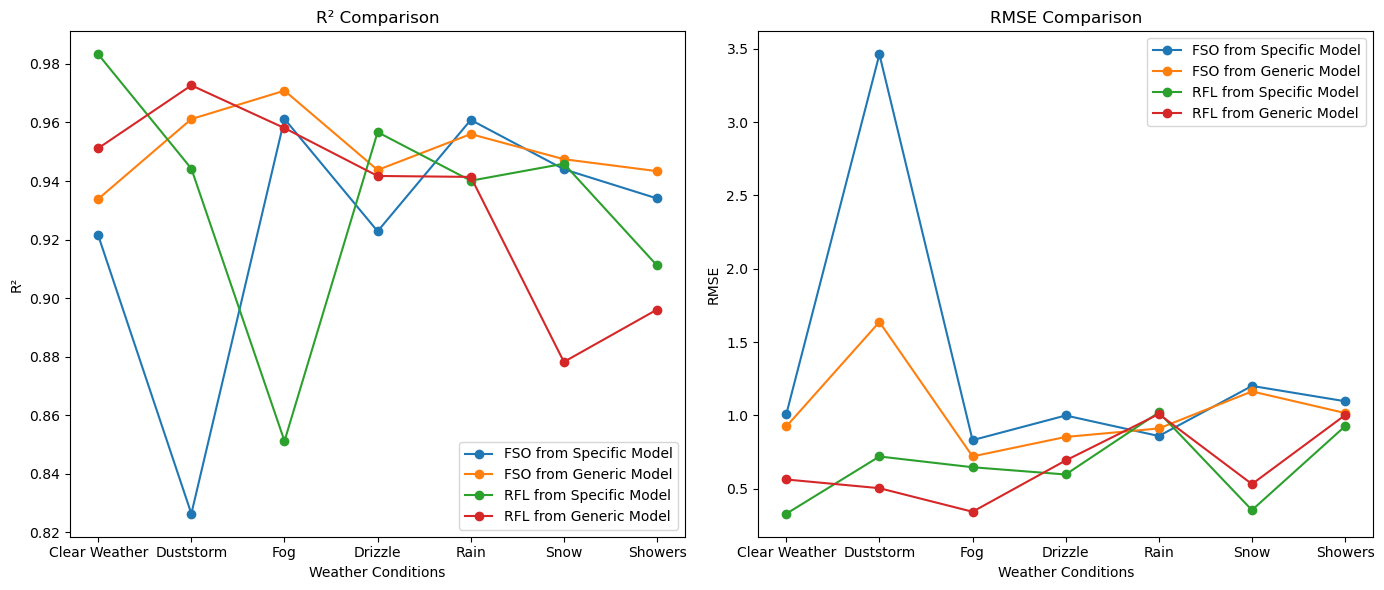

In [11]:
# plotting comparison
weather_conditions = ['SynopCode_0', 'SynopCode_3', 'SynopCode_4', 'SynopCode_5', 'SynopCode_6', 'SynopCode_7', 'SynopCode_8']
r2_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}
rmse_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}

for wc in weather_conditions:
    for var in ['FSO_Att', 'RFL_Att']:
        specific_key = f"{wc}_{var}"
        overall_key = f"{specific_key}_overall"
        
        if specific_key in results:
            r2_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['rmse'])
        if overall_key in results:
            r2_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['rmse'])

x_labels =['Clear Weather','Duststorm','Fog','Drizzle','Rain','Snow','Showers']
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, values in r2_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for label, values in rmse_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.tight_layout()
plt.show()
